<center> 
    <h1>Introducción a la Visión Computacional</h1>
    <h1>Tarea 4</h1>
</center>

### Magíster en Data Science
### U. del Desarrollo

-----------------------
<div align="right">
Fecha de Entrega: Domingo 25, Mayo 2025.
</div>

1. Proponer mejoras al sistema diseñado e implementado originalmete.

2. Volver a investigar, aplicar y/o ajustar un algoritmo diferente al algoritmo utilizado trabajado en la Tarea 2, o bien una extensión de éste. 

3. Implementar métricas de comparación, por ejemplo precisión o una matriz de confusión, junto con otros indicadores tales como tiempos de ejecución de el procesamiento del dataset. La comparación debiera ser con el algoritmo de la Tarea 2. Si resultó que no fue satisfactorio en esta Tarea 2, implementar más de 1 algoritmo o procedimiento para esta Tarea, de manera de poder realizar la comparación mencionada.

4. Escribir un informe o entregar el notebook con comentarios y documentación, incluyendo el análisis (comentando) de la comparación con los resultados de la Tarea 2. Notar que pudiera ser que el resultado es inferior al de la Tarea 2, lo importante es el comentario o discusión del por qué se mejoró o empeoraron los nuevos resultados.

Tan o más importante que los resultados propiamente tales es la discusión y comentarios acerca de la implementación y los resultados. Como siempre, apoyarse en tablas, gráficos e imágenes.


## 1. Objetivo

El objetivo principal de esta tarea consiste en implementar mejoras al sistema de clasificación creado en la tarea 2, sobre el conjunto de datos **Brain Tumor MRI Dataset**, disponible en **Kaggle**.

1. Se decidió realizar una segmentación de los datos de entrenamiento según el corte transversal.
2. Dado que los datos no vienen segmentados por corte, se utilizará un modelo preentrenado para realizar la segmentación.
3. Pasos a seguir:
    - Cargar las imágenes y segmentarlas según sus características.
    - Determinar qué cluster, o todos si es factible, es el más apropiado para entrenar el modelo.
    - Entrenar el modelo con los datos segmentados.
    - Medir los tiempos de ejecución del procesamiento de las imágenes de prueba.
    - Comparar con el resumen de los resultados del modelo anterior, en particular sus métricas y tiempos.


# 2. Carga de datos y Clusterización

In [2]:


# manejo datos
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# visualización y gráficos
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
# Os y glob para manejo de archivos
import os
from glob import glob

# Modelos
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


# Configuración de TensorFlow para evitar advertencias y errores de GPU
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
import absl.logging
absl.logging.set_verbosity('error')  # or 'fatal'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

#medicion de ejecucion
import time




2025-06-08 10:36:36.922293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749393396.936270   13983 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749393396.940449   13983 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749393396.950595   13983 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749393396.950616   13983 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749393396.950618   13983 computation_placer.cc:177] computation placer alr

In [3]:
# Carga de imagenes

def load_and_preprocess(img_path, img_size=(128, 128)):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    return img_array



**Decisión**  
Dado que los datos no vienen marcados según el corte, se utilizó una segmentación no supervisada.


In [4]:
# funcion para cargar y clusterizar imagenes de cada carpeta

def load_and_cluster_images(img_dir, img_size=(128, 128)):
    model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
    filenames = sorted(glob(os.path.join(img_dir, "*.jpg")))
    images = np.array([load_and_preprocess(path,img_size) for path in filenames])
    
    # Extracción de características
    features = model.predict(images, verbose=0)
    
    # Reducción de dimensionalidad
    reduced = PCA(n_components=2).fit_transform(features)
    
    # Clusterización
    kmeans = KMeans(n_clusters=3, random_state=42).fit(reduced)
    labels = kmeans.labels_
    
    return filenames, images, reduced, labels

In [5]:
# Visualización de los resultados

def plot_clusters(reduced, labels):
    plt.figure(figsize=(10, 8))
    sns.set_theme(style="whitegrid")
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels, palette='viridis', s=100, alpha=0.7)
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.title("Clusters de imagens (PCA + KMeans)")
    plt.show()


In [6]:
# Mostrar imágenes de cada cluster
def show_cluster_images(filenames, labels, img_size=(128, 128),samples=5):
    unique_labels = sorted(set(labels))

    for cluster_id in unique_labels:
        # Get all images in this cluster
        cluster_indices = [i for i, lbl in enumerate(labels) if lbl == cluster_id]
        
        print(f"\n Cluster {cluster_id}")

        plt.figure(figsize=(15, 3))
        
        for i, idx in enumerate(cluster_indices[:samples]):
            img_path = filenames[idx]
            img = image.load_img(img_path, target_size=img_size)
            
            plt.subplot(1, samples, i + 1)
            plt.imshow(img)
            plt.title(os.path.basename(img_path), fontsize=8)
            plt.axis('off')

        plt.tight_layout()
        plt.show()



In [7]:

filenames_glioma, images_glioma, reduced_glioma, labels_glioma = load_and_cluster_images('data/Training/glioma', img_size=(128, 128))

I0000 00:00:1749393400.151735   13983 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1749393407.311847   14047 service.cc:152] XLA service 0x7f695c004370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749393407.311880   14047 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-06-08 10:36:47.340745: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749393407.736158   14047 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749393411.990763   14047 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


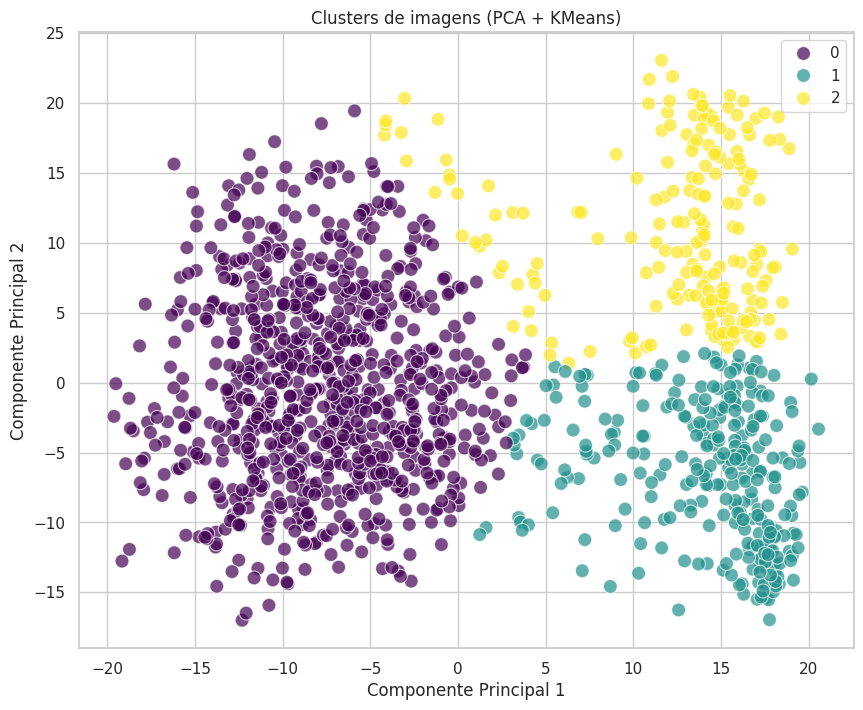

In [8]:
plot_clusters(reduced_glioma, labels_glioma)


 Cluster 0


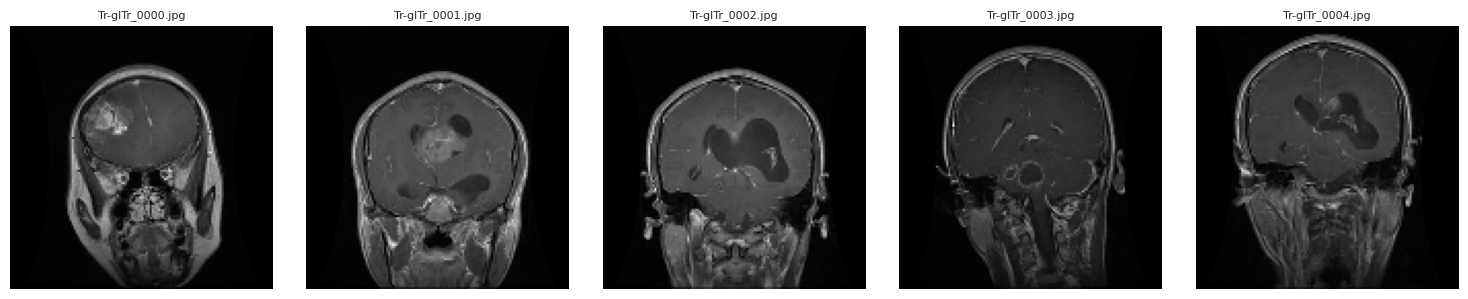


 Cluster 1


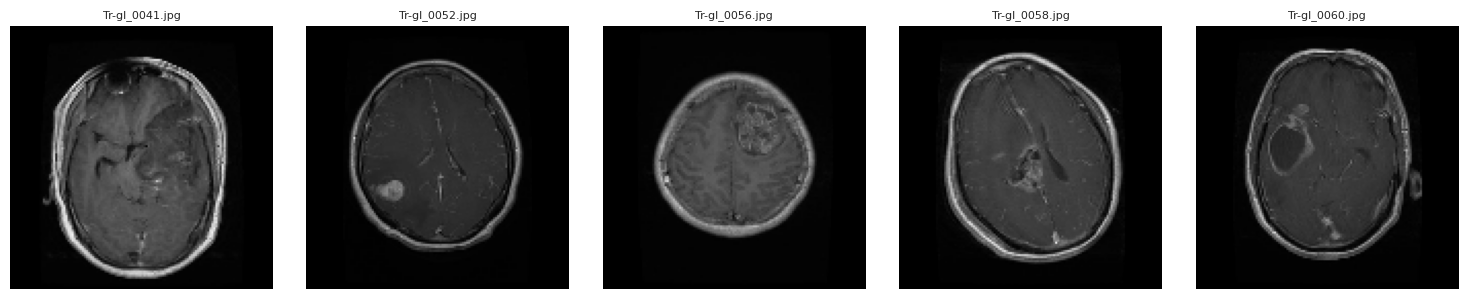


 Cluster 2


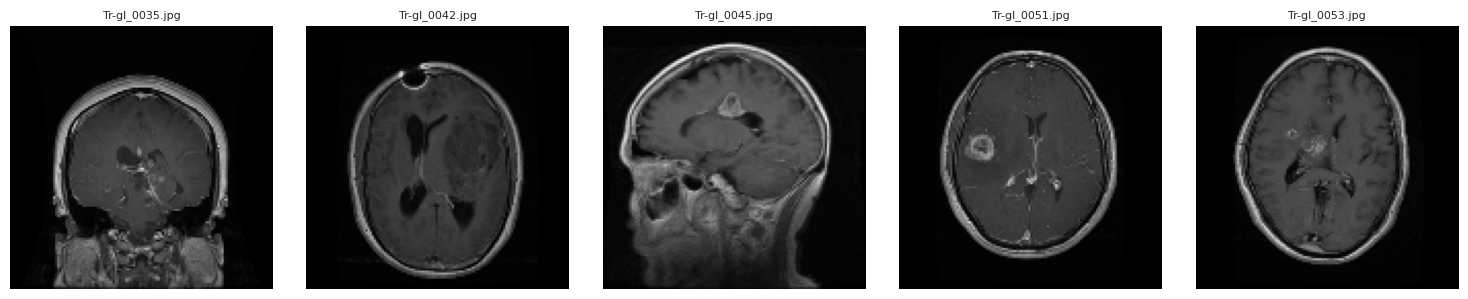

In [9]:
show_cluster_images(filenames_glioma, labels_glioma, img_size=(128, 128), samples=5)

In [10]:
filenames_meningioma, images_meningioma, reduced_meningioma, labels_meningioma = load_and_cluster_images('data/Training/meningioma', img_size=(128, 128))

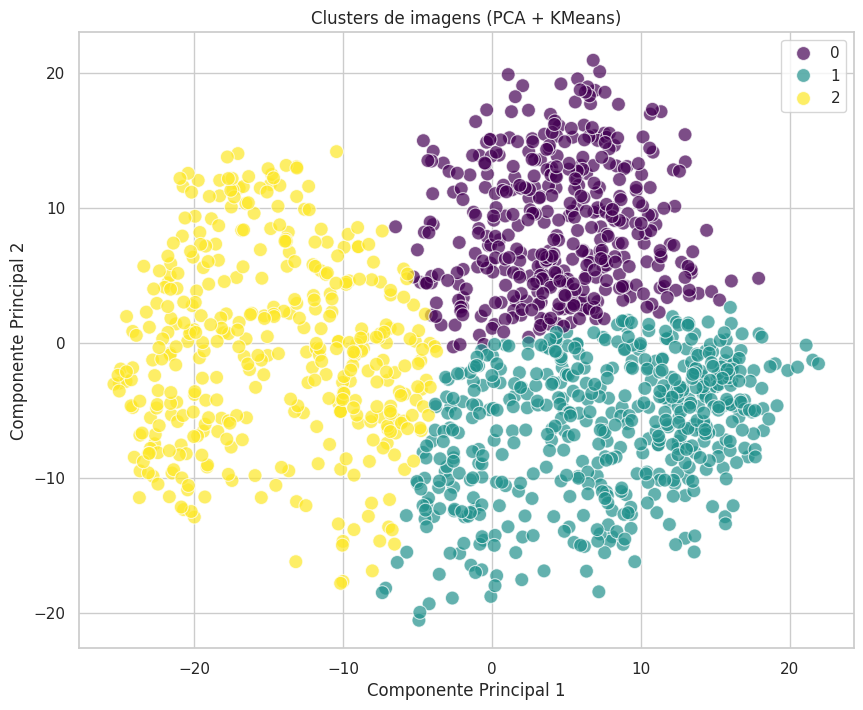

In [11]:
plot_clusters(reduced_meningioma, labels_meningioma)


 Cluster 0


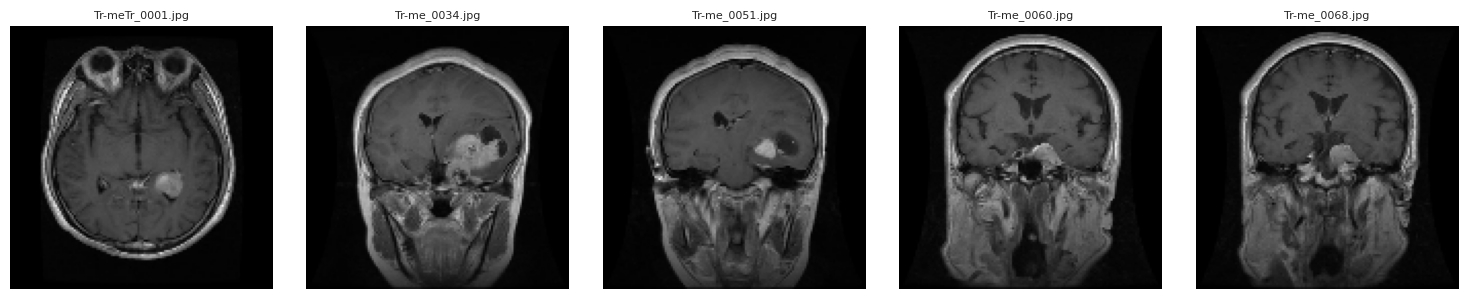


 Cluster 1


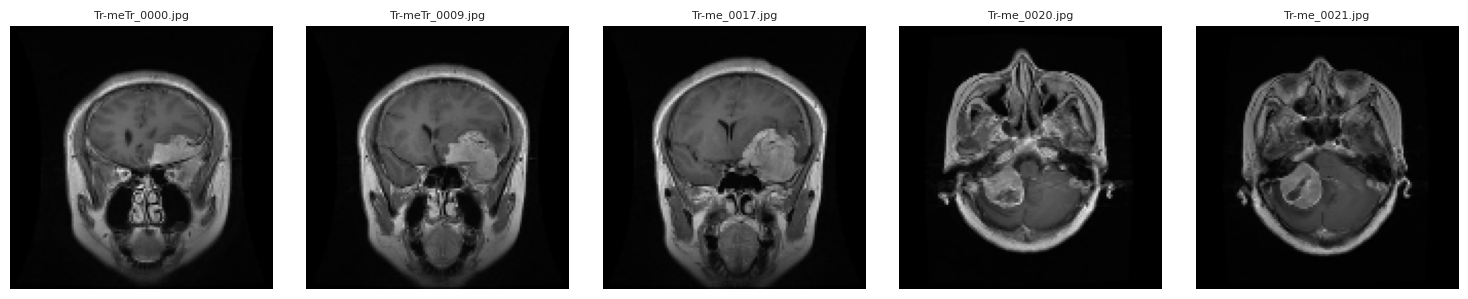


 Cluster 2


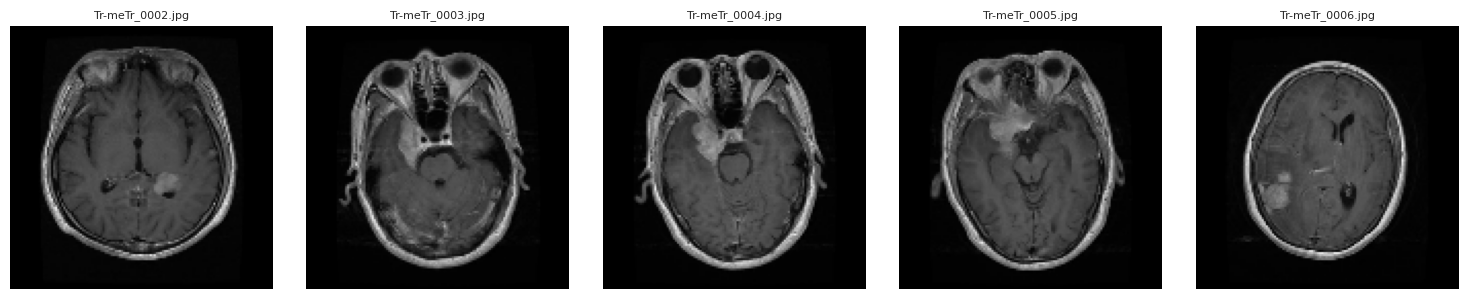

In [12]:
show_cluster_images(filenames_meningioma, labels_meningioma, img_size=(128, 128), samples=5)

In [14]:
filenames_notumor, images_notumor, reduced_notumor, labels_notumor = load_and_cluster_images('data/Training/notumor', img_size=(128, 128))

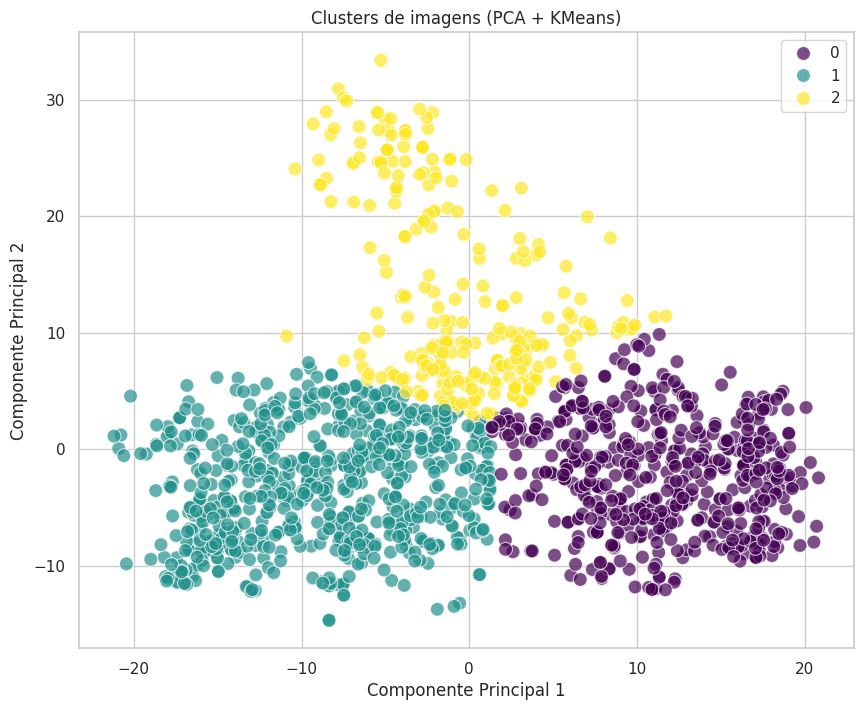

In [15]:
plot_clusters(reduced_notumor, labels_notumor)


 Cluster 0


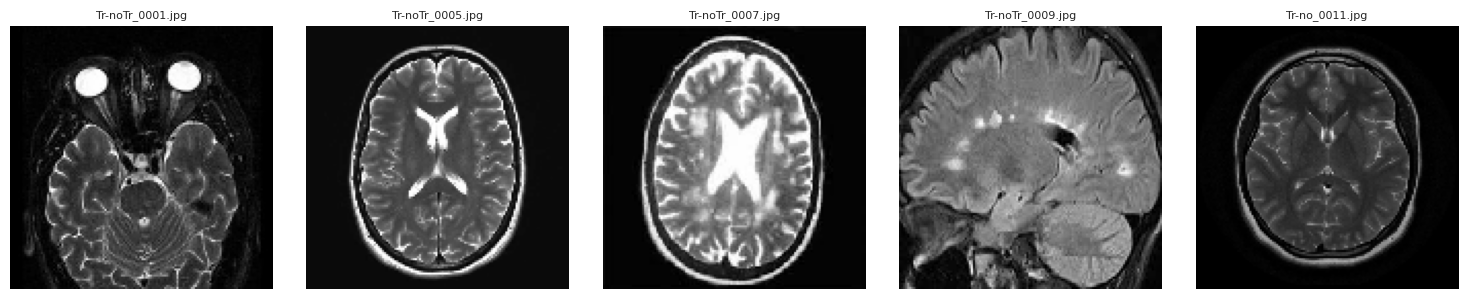


 Cluster 1


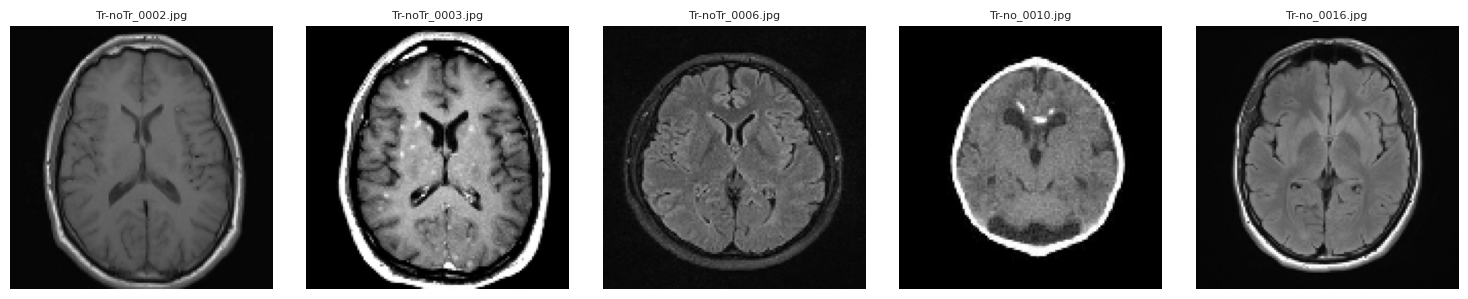


 Cluster 2


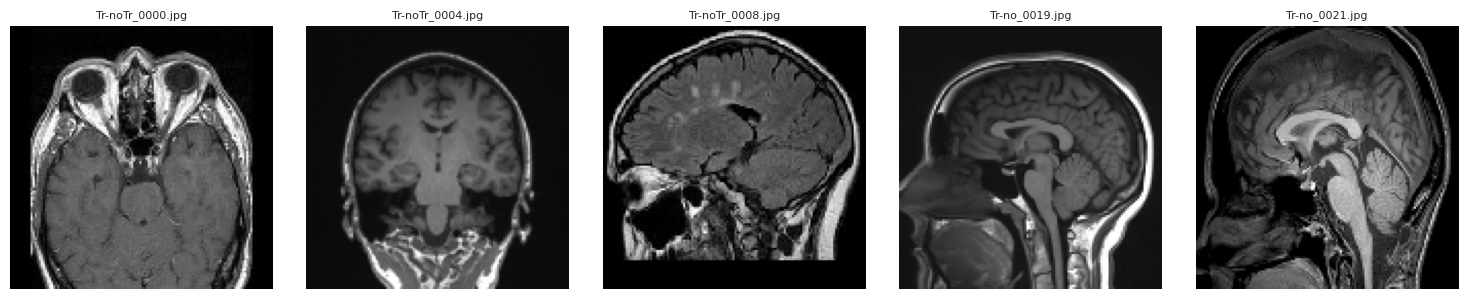

In [18]:
show_cluster_images(filenames_notumor, labels_notumor, img_size=(128, 128), samples=5)

In [19]:
filenames_pituitary, images_pituitary, reduced_pituitary, labels_pituitary = load_and_cluster_images('data/Training/pituitary', img_size=(128, 128))

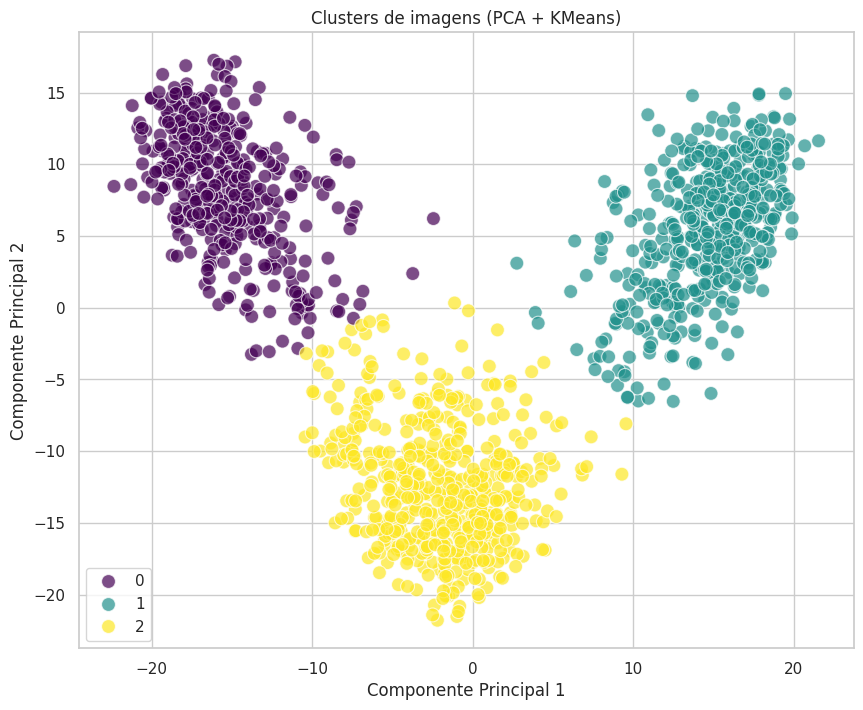

In [20]:
plot_clusters(reduced_pituitary, labels_pituitary)


 Cluster 0


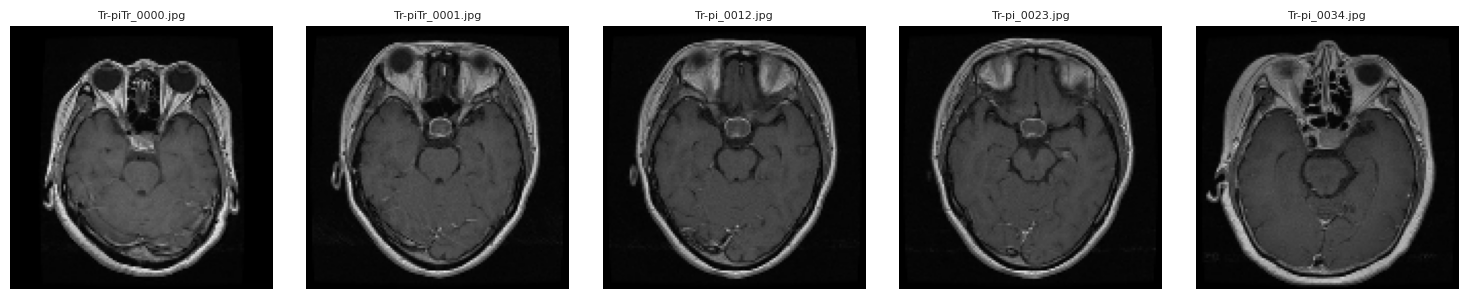


 Cluster 1


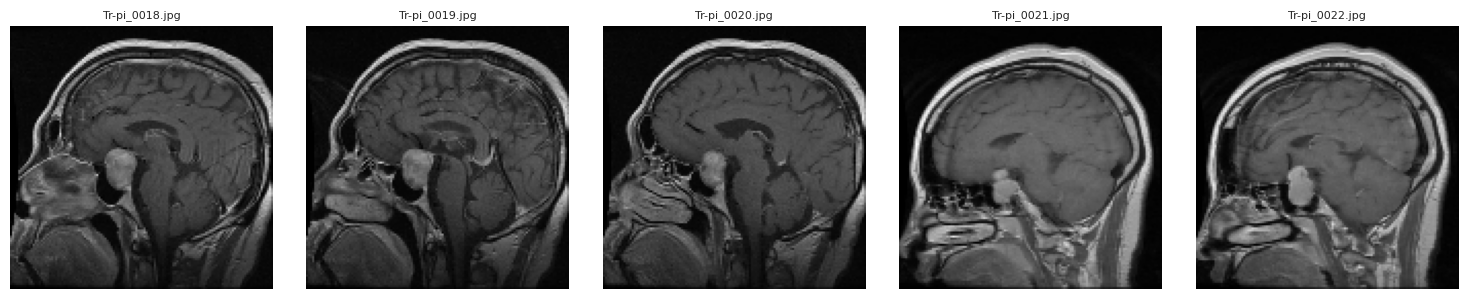


 Cluster 2


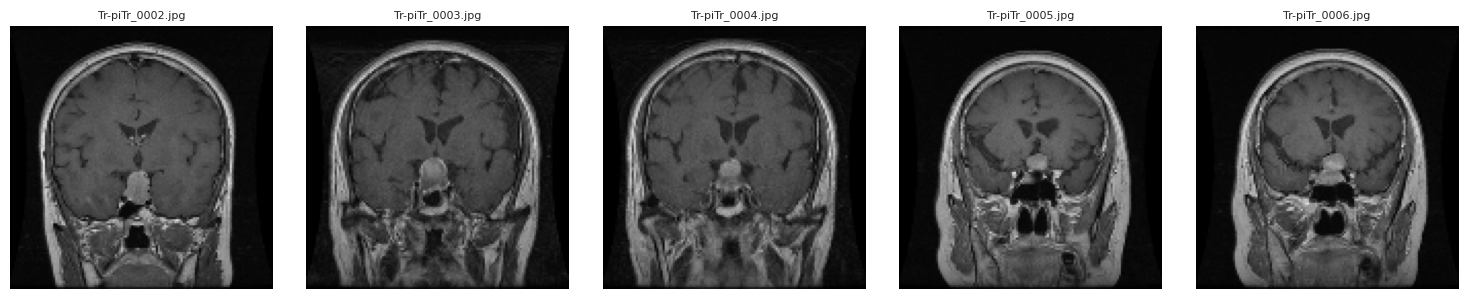

In [21]:
show_cluster_images(filenames_pituitary, labels_pituitary, img_size=(128, 128), samples=5)

**Decisión**  
Los clusters de corte axial parecen ser los mejor comportados en cada caso, por lo que se entrenara el modelo basado en estos clusters.


In [43]:
len(filenames_pituitary)

1457

In [38]:
training_paths = [filenames_pituitary, filenames_glioma, filenames_meningioma, filenames_notumor]
training_labels = ['pituitary', 'glioma', 'meningioma', 'notumor']
# Crear un DataFrame para almacenar las rutas y etiquetas
data = {'path': [], 'Class': []}
for paths, label in zip(training_paths, training_labels):
    data['path'].extend(paths)
    data['Class'].extend([label] * len(paths)) 
df = pd.DataFrame(data) 

In [42]:
df.shape # Muestra aleatoria de 10 filas del DataFrame

(5712, 2)

In [40]:
# Visualización de las clases y sus conteos
def plot_class_distribution(df):
    """ Visualiza la distribución de clases en el conjunto de entrenamiento.
    Args:
        tr_df (DataFrame): DataFrame que contiene las rutas de las imágenes y sus etiquetas.
    """

    sns.set_style("whitegrid")

    plt.figure(figsize=(12, 6))

    ax = sns.countplot(data=df, x='Class', order=df['Class'].value_counts().index)

    ax.set_title('Distribución de Clases en el Conjunto de Entrenamiento')
    ax.set_xlabel('Clases')
    ax.set_ylabel('Conteo')
    plt.xticks(rotation=25)


    # añadir cantidad dentro de las barras
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()//2), 
                    ha='center', 
                    va='bottom', 
                    fontsize=15, 
                    color='w', 
                    weight='bold', 
                    rotation=90, 
                    xytext=(0, 5), 
                    textcoords='offset points')
    
    #añadir total de imágenes arriba a la derecha 
    total = len(df)
    ax.annotate(f'Total de imagenes: {total}', 
                (0.9, 0.90), 
                xycoords='axes fraction', 
                ha='right', 
                va='top', 
                fontsize=15, 
                color='black',  
                rotation=0, 
                xytext=(0, 5), 
                textcoords='offset points')
    plt.tight_layout()
    plt.show()

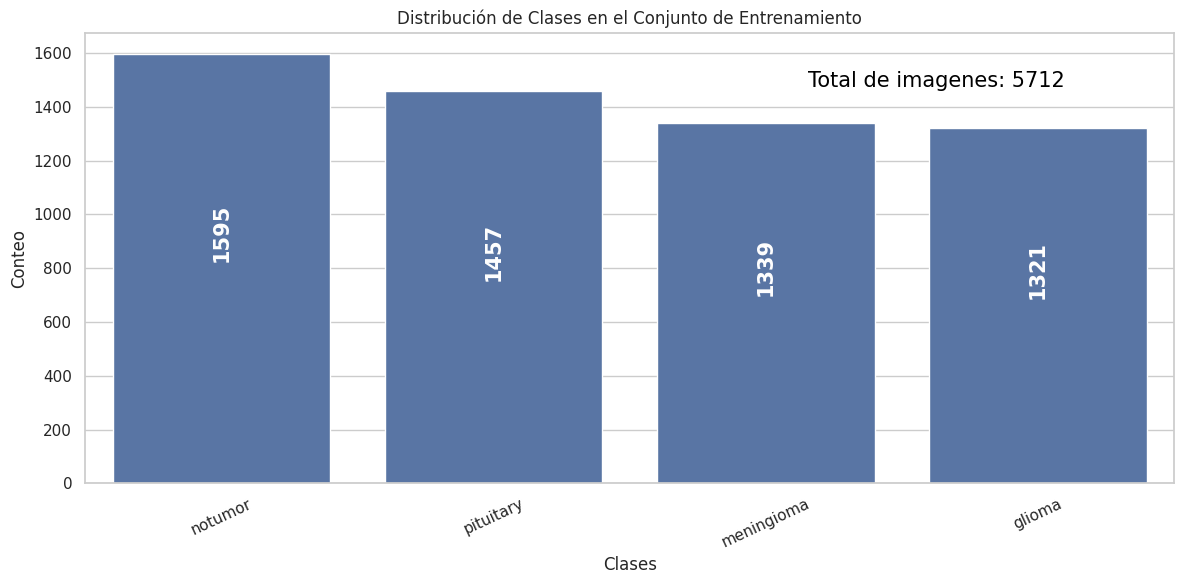

In [41]:
plot_class_distribution(df)